### 0.Imports

In [59]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import polars as pl

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Vigilar progreso bucles
# -----------------------------------------------------------------------
from tqdm import tqdm

# Gestionar los warnings
# -----------------------------------------------------------------------
import warnings

# modificar el path
# -----------------------------------------------------------------------
import sys
sys.path.append("..")

# importar funciones de soporte
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.soporte_outliers as so
import src.ab_testing_support as ats

# evaluar objetos literales
# -----------------------------------------------------------------------
from ast import literal_eval 

# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Introduction - Madrid rental prices - Preprocessing

## 1.1 Data import

In [60]:
pd.set_option("display.max_columns",40)
rent_df = pd.read_csv("../datos/cleaned/rent_df_cleaned_v1.csv", index_col=0)
rent_df.head()

,numPhotos,price,propertyType,size,exterior,rooms,bathrooms,distance,priceByArea,hasPlan,hasLift,parkingSpace_included_in_listing,floor_grouped,municipality_grouped
1,12,750.0,flat,60.0,True,1,1,7037,12.500000,False,True,False,3,Madrid
2,21,750.0,flat,70.0,True,2,1,16145,10.714286,True,False,False,0,Other
3,28,400.0,penthouse,67.0,True,2,2,55041,5.970149,False,False,False,2,Other
6,11,590.0,flat,70.0,True,3 or more,2,56596,8.428571,False,False,False,unknown,Other
7,17,684.0,studio,45.0,True,0,1,10656,15.200000,True,False,False,unknown,Madrid


In [61]:
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 337 entries, 1 to 449
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   numPhotos                         337 non-null    int64  
 1   price                             337 non-null    float64
 2   propertyType                      337 non-null    object 
 3   size                              337 non-null    float64
 4   exterior                          337 non-null    bool   
 5   rooms                             337 non-null    object 
 6   bathrooms                         337 non-null    int64  
 7   distance                          337 non-null    int64  
 8   priceByArea                       337 non-null    float64
 9   hasPlan                           337 non-null    bool   
 10  hasLift                           337 non-null    bool   
 11  parkingSpace_included_in_listing  337 non-null    bool   
 12  floor_grouped

In [62]:
rent_df["bathrooms"] = rent_df["bathrooms"].astype("O")

# 2. Preprocessing

## 2.1 Missing values

Before developing a strategy for handling missing values, let's check if that is even necessary for the data at hand:

In [63]:
rent_df.isna().sum() / rent_df.shape[0]

numPhotos                           0.0
price                               0.0
propertyType                        0.0
size                                0.0
exterior                            0.0
rooms                               0.0
bathrooms                           0.0
distance                            0.0
priceByArea                         0.0
hasPlan                             0.0
hasLift                             0.0
parkingSpace_included_in_listing    0.0
floor_grouped                       0.0
municipality_grouped                0.0
dtype: float64

No imputation strategy is needed, as the categories with any missing data have already been handled with strategies that do not incur in data leakage, such as adding 'unknown' categories for categorical data and recalculating calculated columns.

## 2.2 Outliers

Let's visually inspect univariate outliers by plotting boxplots:

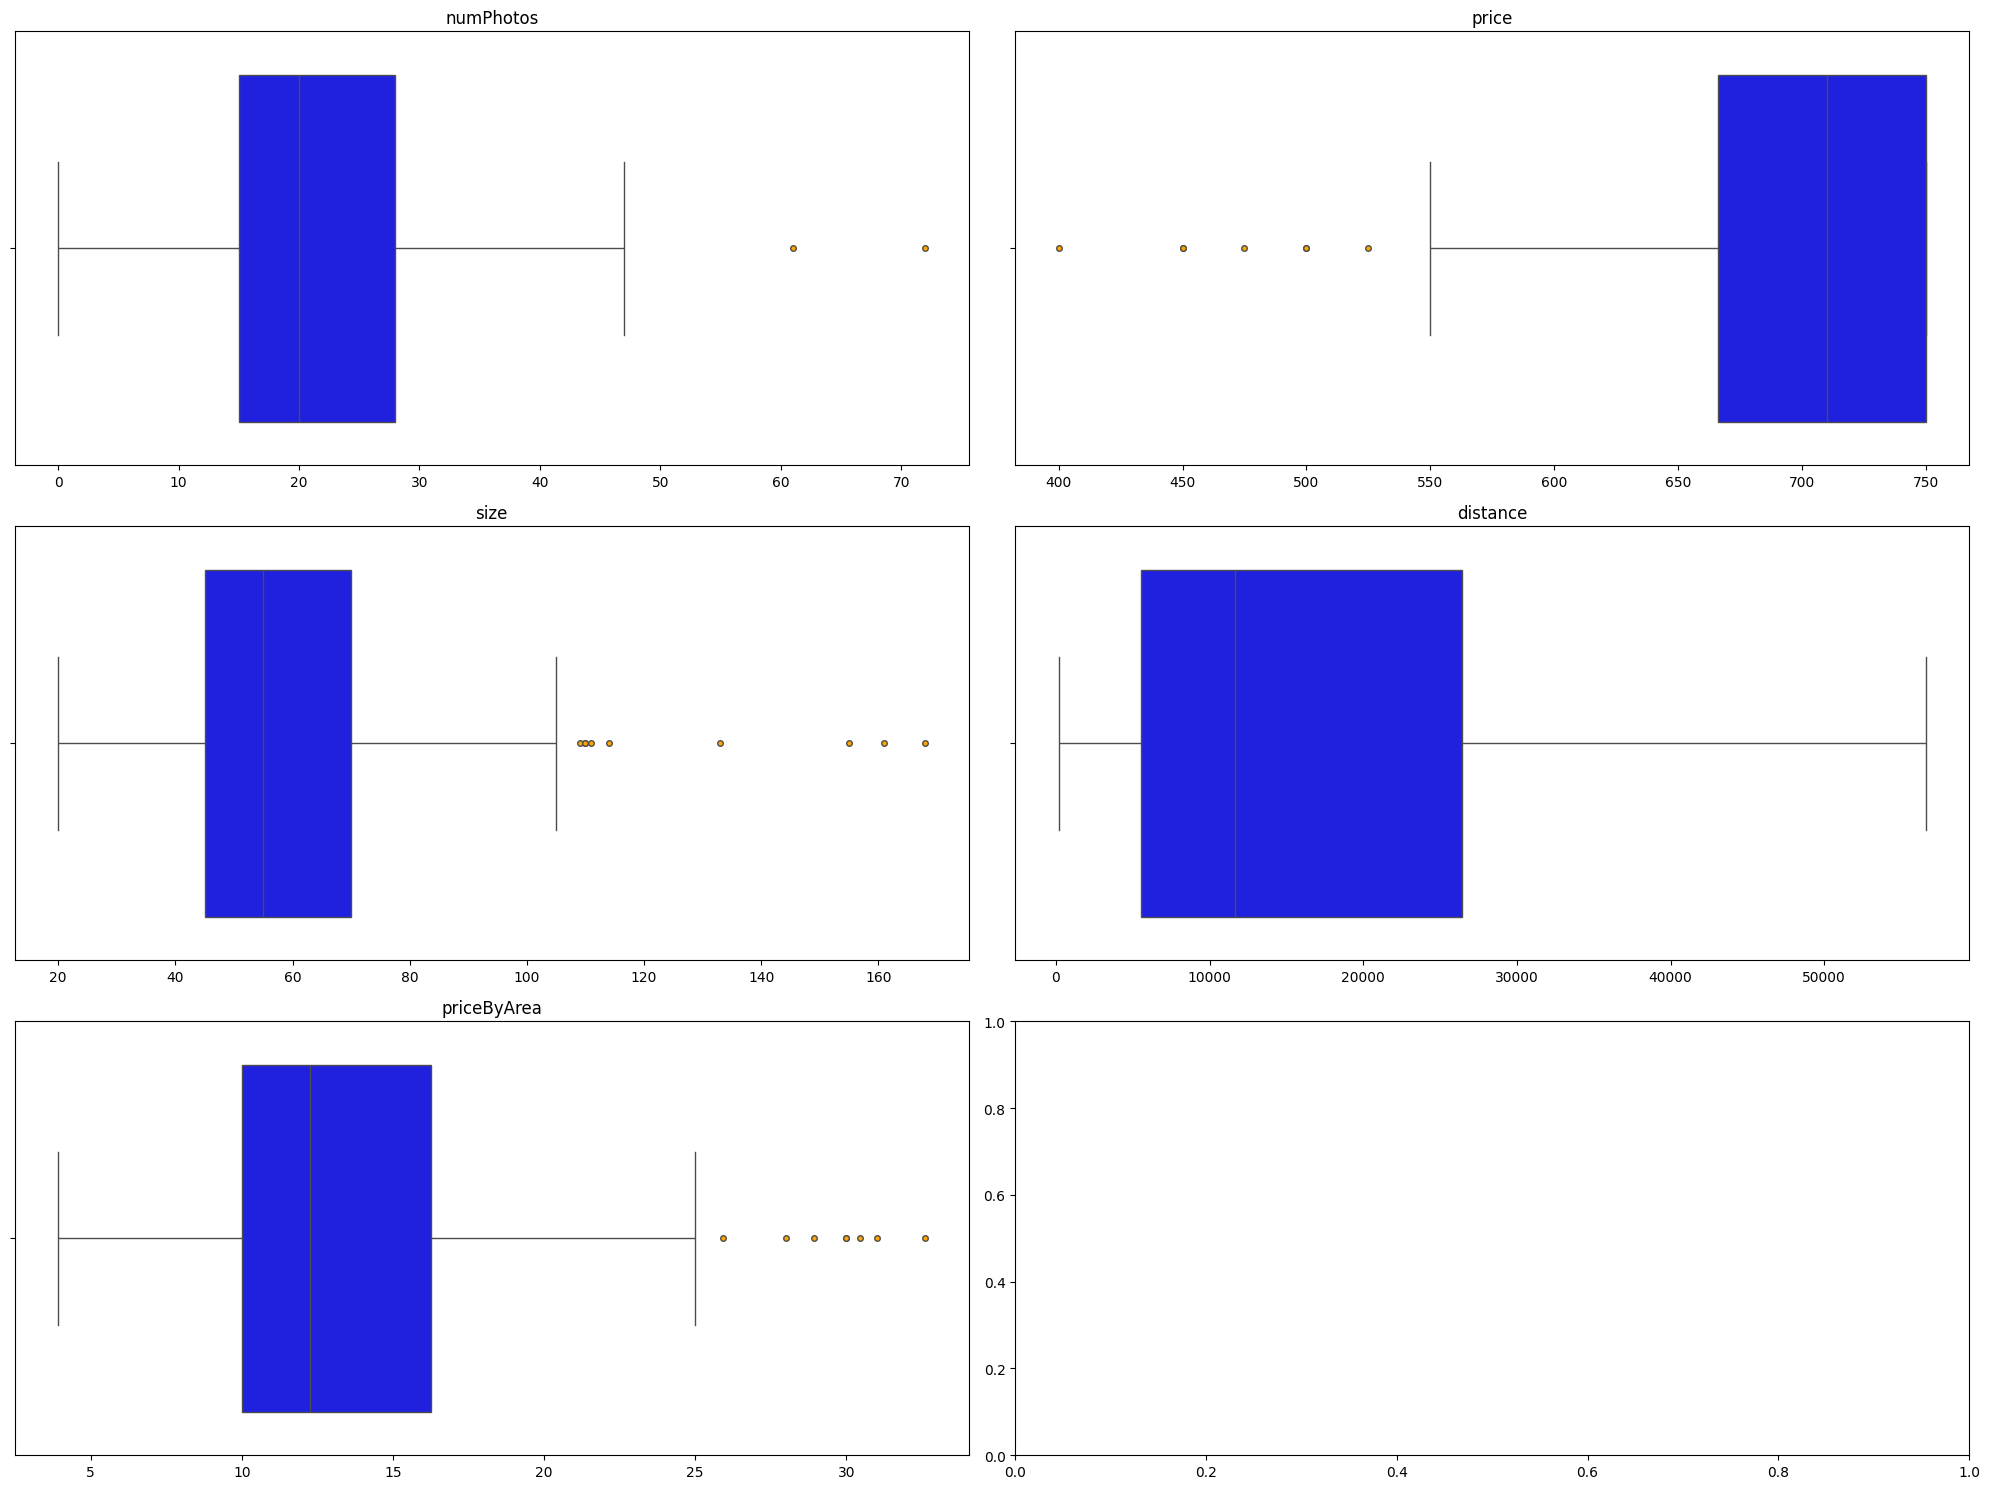

In [64]:
gestor_outliers = so.GestionOutliersUnivariados(rent_df)

gestor_outliers.visualizar_outliers_univariados()

Outlier in bathrooms can be ignored as it is actually a categorical feature.



The initial strategy will be to not handle the outliers and just scale the features to observe the behaviour of the model.

## 2.3 Encoding

In [65]:
rent_df.select_dtypes(include=["O","category",bool])

,propertyType,exterior,rooms,bathrooms,hasPlan,hasLift,parkingSpace_included_in_listing,floor_grouped,municipality_grouped
1,flat,True,1,1,False,True,False,3,Madrid
2,flat,True,2,1,True,False,False,0,Other
3,penthouse,True,2,2,False,False,False,2,Other
6,flat,True,3 or more,2,False,False,False,unknown,Other
7,studio,True,0,1,True,False,False,unknown,Madrid
...,...,...,...,...,...,...,...,...,...
445,flat,True,2,1,False,True,True,2,Other
446,flat,True,1,1,True,True,False,1,Other
447,flat,True,1,1,False,True,True,4 or more,Madrid
448,flat,True,2,1,False,False,False,1,Other


Realizando AB-Testing de la variable 'propertyType'
Las muestras de los siguientes grupos son pequeñas:


propertyType
duplex       13
penthouse    10
studio       48
Name: price, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE KRUSKAL-WALLIS TEST:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.366 > alpha 0.05, en la variable propertyType no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------




Realizando AB-Testing de la variable 'exterior'
Las muestras de los siguientes grupos son pequeñas:


exterior
False    62
Name: price, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.448 > alpha 0.05, en la variable exterior no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------




Realizando AB-Testing de la variable 'rooms'
Las muestras de los siguientes grupos son pequeñas:


rooms
0            49
3 or more    51
Name: price, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE KRUSKAL-WALLIS TEST:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.047 > alpha 0.05, en la variable rooms, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grupos compa

,group1,group2,meddiff,p-adj,reject_H0
4,1,3 or more,30.0,0.04,True


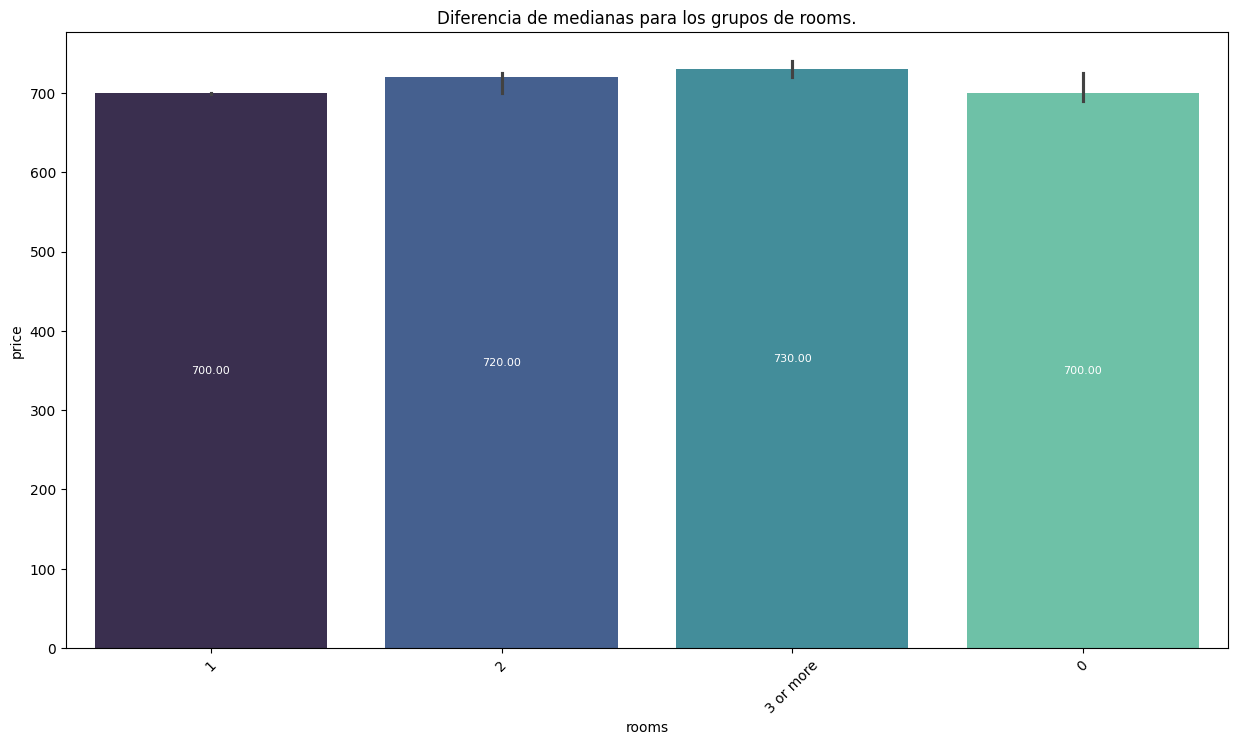




Realizando AB-Testing de la variable 'bathrooms'
Las muestras de los siguientes grupos son pequeñas:


bathrooms
2    28
Name: price, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.467 > alpha 0.05, en la variable bathrooms no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grupos 

,group1,group2,meddiff,p-adj,reject_H0


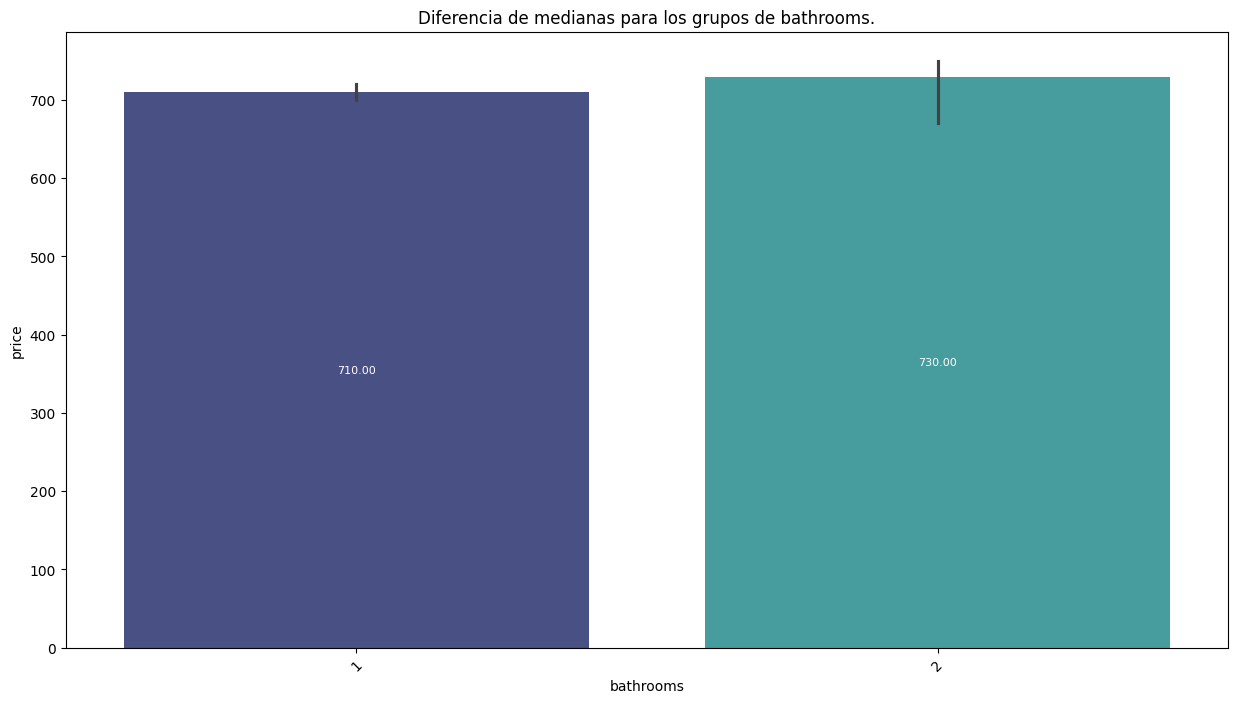




Realizando AB-Testing de la variable 'hasPlan'
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.306 > alpha 0.05, en la variable hasPlan no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótes

,group1,group2,meddiff,p-adj,reject_H0


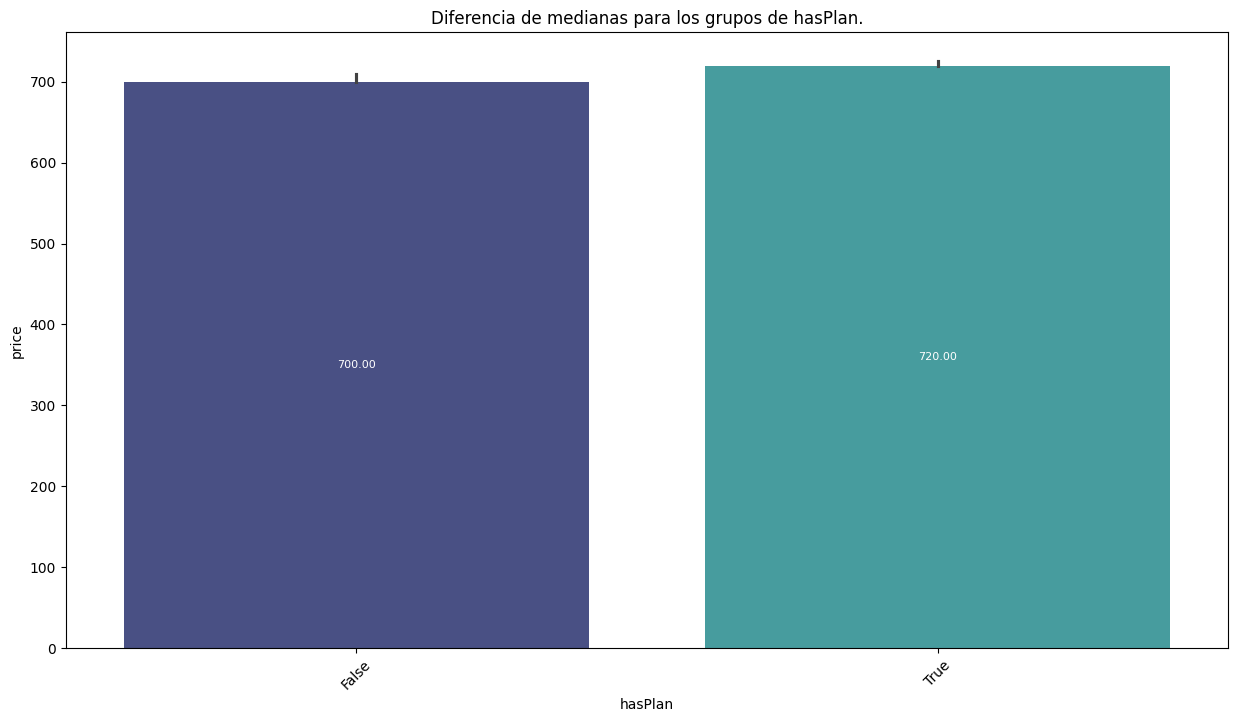




Realizando AB-Testing de la variable 'hasLift'
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.025 > alpha 0.05, en la variable hasLift, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alt

,group1,group2,meddiff,p-adj,reject_H0
0,False,True,20.0,0.025,True


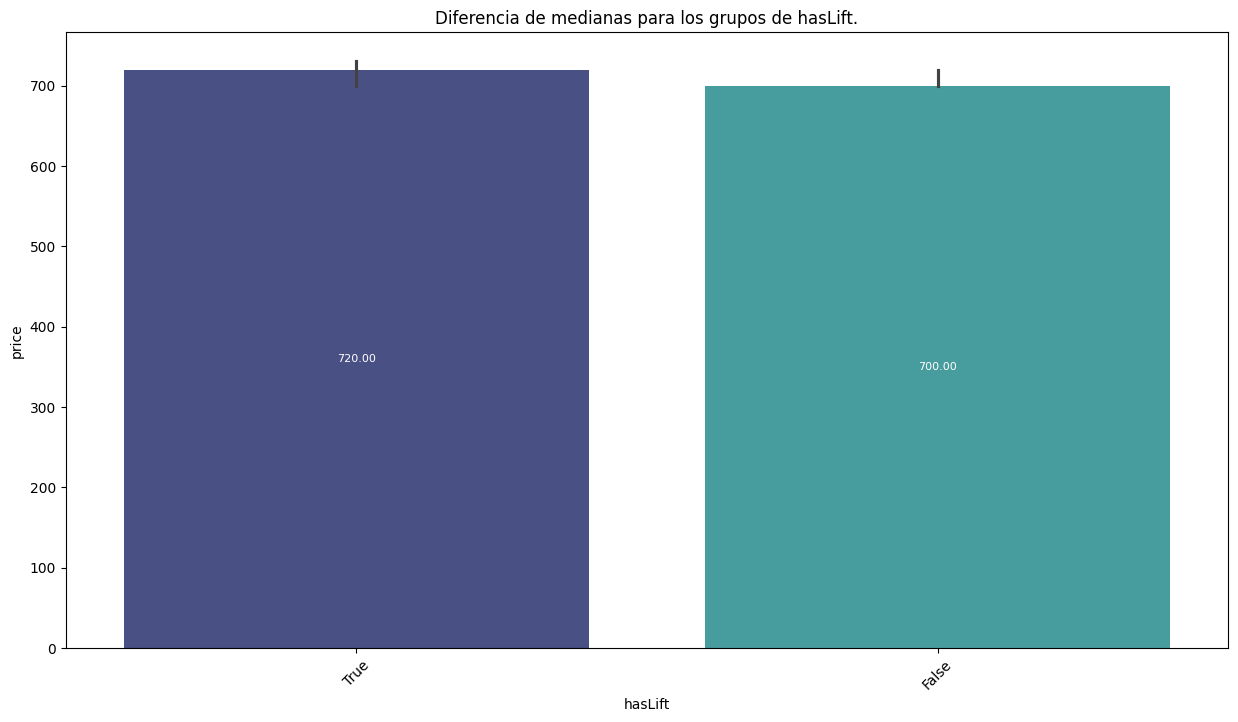




Realizando AB-Testing de la variable 'parkingSpace_included_in_listing'
Las muestras de los siguientes grupos son pequeñas:


parkingSpace_included_in_listing
True    70
Name: price, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.864 > alpha 0.05, en la variable parkingSpace_included_in_listing no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las 

,group1,group2,meddiff,p-adj,reject_H0


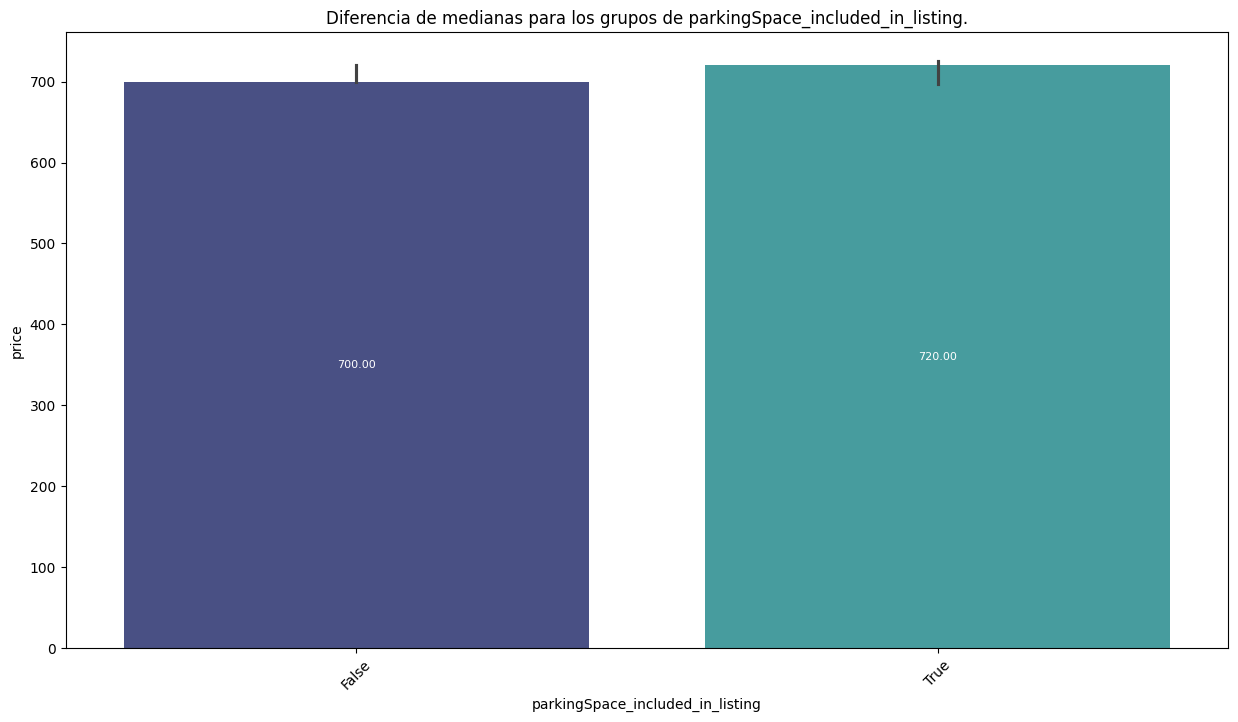




Realizando AB-Testing de la variable 'floor_grouped'
Las muestras de los siguientes grupos son pequeñas:


floor_grouped
0            60
0.5           6
1            68
2            56
3            47
4 or more    49
unknown      51
Name: price, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE KRUSKAL-WALLIS TEST:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.001 > alpha 0.05, en la variable floor_grouped, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grup

,group1,group2,meddiff,p-adj,reject_H0
4,0,4 or more,30.0,0.002,True
20,4 or more,unknown,-35.0,0.004,True


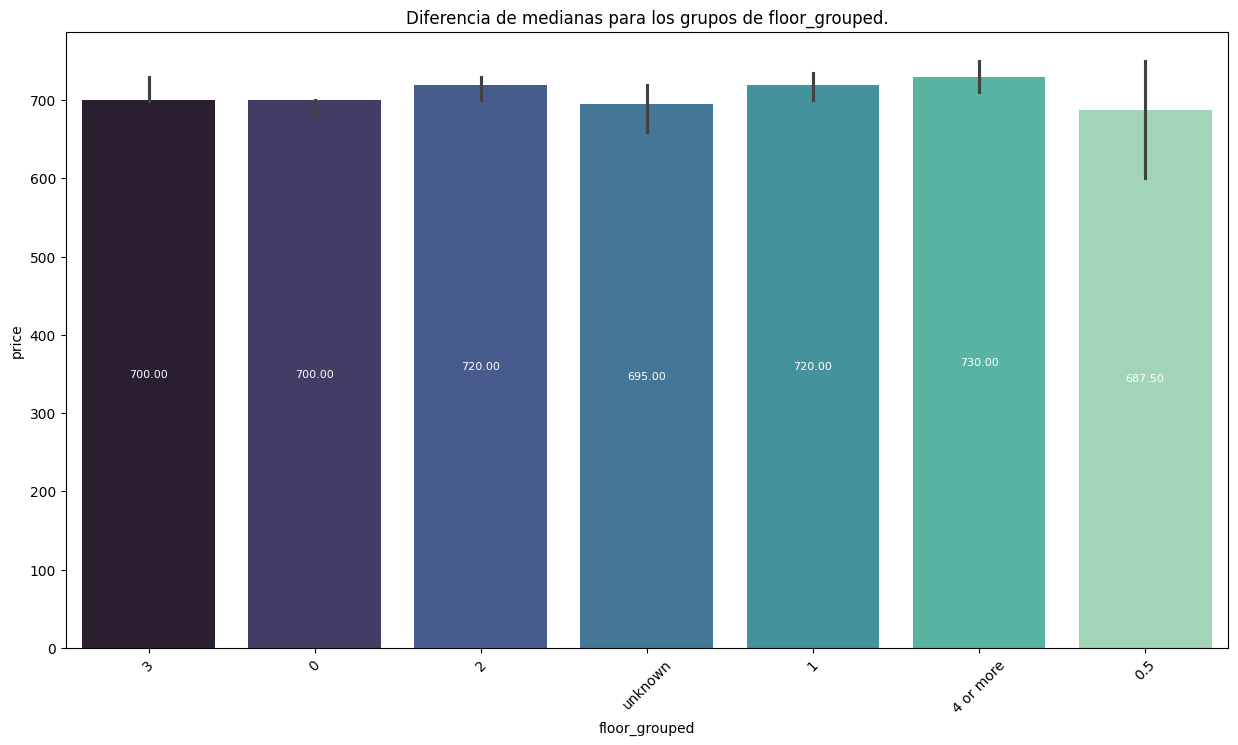




Realizando AB-Testing de la variable 'municipality_grouped'
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.002 > alpha 0.05, en la variable municipality_grouped, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados 

,group1,group2,meddiff,p-adj,reject_H0
0,Madrid,Other,-20.0,0.002,True


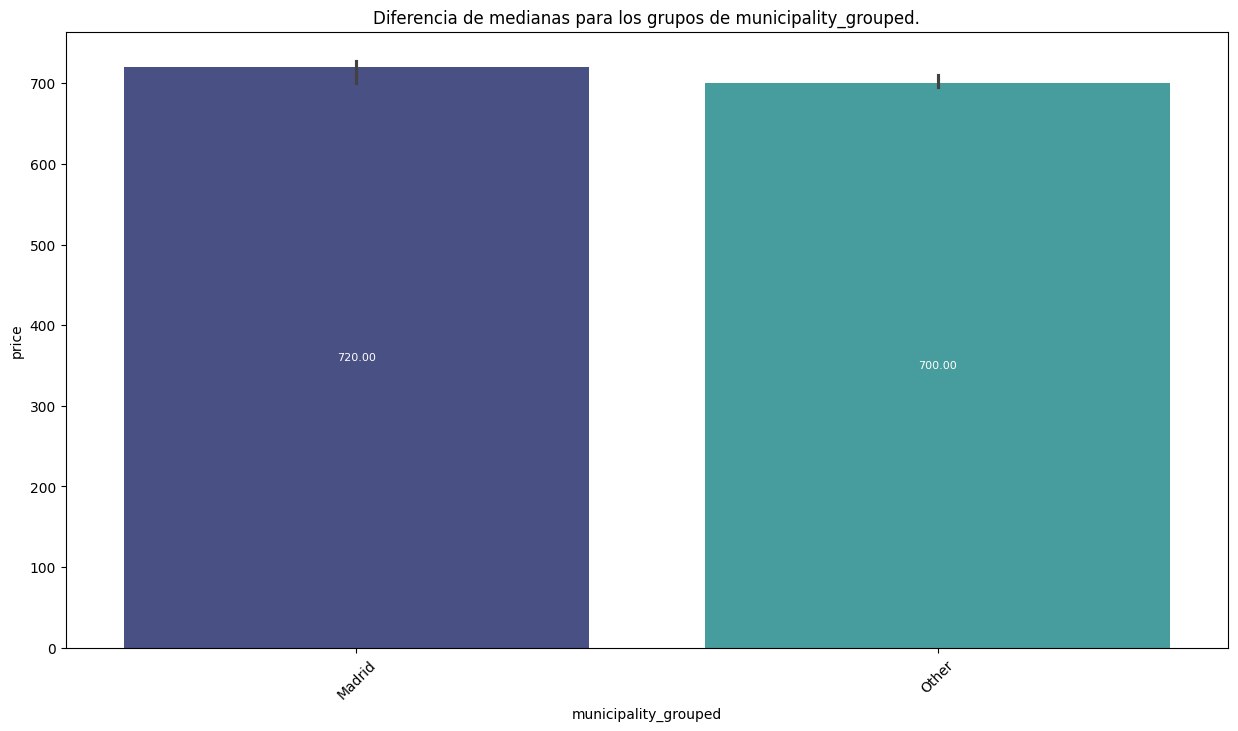

In [66]:
# ignorar warnings momentaneamente para evitar warnigns del soporte
warnings.filterwarnings("ignore")

tester = ats.AB_testing(rent_df, "price", 0.05, verbose=False)

for columna_categorica in rent_df.select_dtypes(include=["O","category",bool]):
    print(f"Realizando AB-Testing de la variable '{columna_categorica}'")
    print("===============================================")
    tester.evaluar_ab_testing(columna_categorica)
    print("\n\n")


# resturar warnings
warnings.filterwarnings("default")

Due to categorical features not showing real big effects even when differences are significant, the decision is to not include them in a first model not to overcomplicate it at first. The reason to back this up is that were there any effects, they would come from interactions, and the idea is to use a very simple explainable model such as linear regression or decision tree.

## 2.4 Scaling

As seen previously, there are only a few outliers in the selected columns. Therefore, the idea is to retain their values as they might not impact the model and could always potentially represent the distribution. Thus, the method of choice is a robust scaler.

# 3. Feature engineering

The algorithm of choice for a first approach will be of course Linear Regression. Of course, this is an algorithm that cannot detect interactions or non-linear interactions, and therefore needs some help to get there. A simple Decision Tree could help either identify important interactions or be used with proper tuning to replace linear regression altogether. Some interesting interactions to explore have already been identified during EDA.

Additionally, some characteristics could be extracted from fields like description. Or some information could be added to the dataset to enrich it, such as quality of life per neighborhood, etc.

Also, two models could be created such as one for houses in Madrid and Houses outside it. However, the focus now is in creating a simple model to not use a sledgehammer to crack a nut.

Nevertheless, there is one feature engineering transformation that can really aid the first model. Let's look at the following relationship between "priceByArea" and "size":

<Axes: xlabel='priceByArea', ylabel='size'>

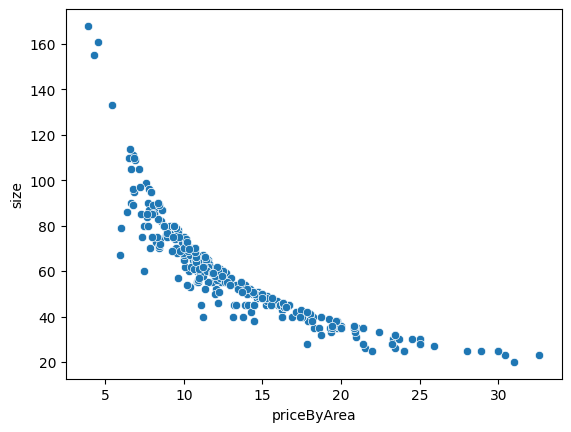

In [67]:
sns.scatterplot(rent_df,
                x="priceByArea",
                y="size")

These two follow a seemingly reciprocal relationship where y=1/x that is almost perfect. Size is a feature that is supposed to be known for every rental unit, where price is the labeled target. If price is the target, we can leverage this relationship by predicting "priceByArea" instead and then calculating the price by multiplying area to the prediction:

$$
\text{priceByArea\_pred} = \hat{y} = \text{model.predict}(X_\text{test})
$$

$$
\text{price\_pred} = \hat{y} \times \text{size}
$$

Then, feature engineering comes in to make this relationship easier to capture as linear by calculating the reciprocal of size:

<Axes: xlabel='priceByArea', ylabel='reciprocal_size'>

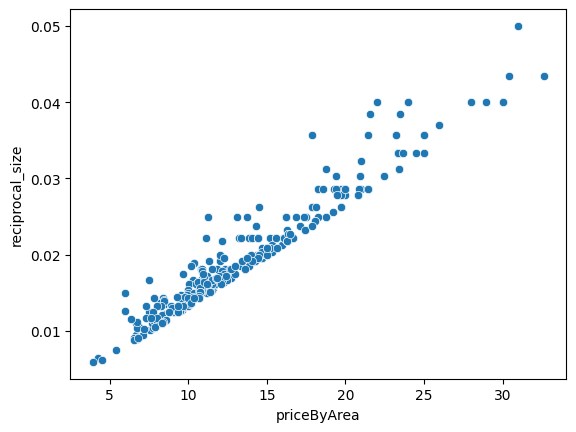

In [68]:
rent_df['reciprocal_size'] = 1 / rent_df['size']

sns.scatterplot(rent_df,
                x="priceByArea",
                y="reciprocal_size")

<Axes: xlabel='priceByArea', ylabel='reciprocal_distance'>

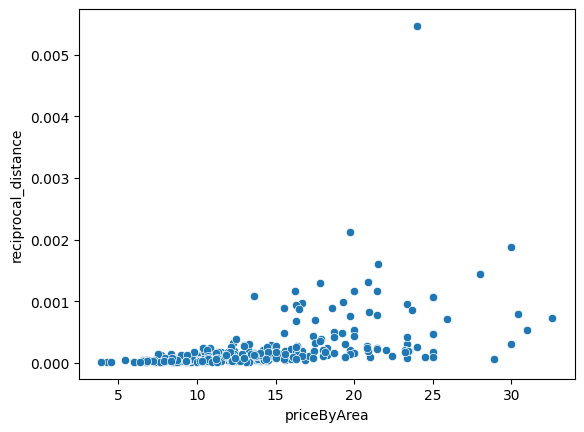

In [69]:
rent_df['reciprocal_distance'] = 1 / rent_df['distance']

sns.scatterplot(rent_df,
                x="priceByArea",
                y="reciprocal_distance")

Now, we can go to the modelling notebook. The same ``rent_df_cleaned.csv`` dataset file will be used, as this notebook is just for preprocessing exploration purposes. All preprocessing operations will be performed in a pipelined manner through scikit-learn methods.